# Final Project - Unsupervised Learning

For my final project, I decided to use a Kaggle data set "Women's E-Commerce Clothing Reviews" which is a real world data set which has been anonymized, including replacing references to the company name with the term "retailer".    

https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

In [259]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

# For text cleaning/preprocessing
import string, re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler

# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score 

# For Nonnegative Matrix Factorization
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix, csr_matrix

#for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Importing Data and Initial EDA

With the initial import, I am going to look for insights into the data and missing values in the data. 

In [ ]:
df_0 = pd.read_csv('data/Womens_Clothing_Reviews.csv')
print(df_0.columns)
print(df_0.describe())
print('Titles missing', df_0['Title'].isna().sum())
print('Reviews missing', df_0['Review Text'].isna().sum())
print('Division missing', df_0['Division Name'].isna().sum())
print('Department missing', df_0['Department Name'].isna().sum())
print('Class missing', df_0['Class Name'].isna().sum())
df_0.head()

Index(['Unnamed: 0', 'Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')
         Unnamed: 0   Clothing ID           Age        Rating  \
count  23486.000000  23486.000000  23486.000000  23486.000000   
mean   11742.500000    918.118709     43.198544      4.196032   
std     6779.968547    203.298980     12.279544      1.110031   
min        0.000000      0.000000     18.000000      1.000000   
25%     5871.250000    861.000000     34.000000      4.000000   
50%    11742.500000    936.000000     41.000000      5.000000   
75%    17613.750000   1078.000000     52.000000      5.000000   
max    23485.000000   1205.000000     99.000000      5.000000   

       Recommended IND  Positive Feedback Count  
count     23486.000000             23486.000000  
mean          0.822362                 2.535936  
std           0.382216                 5.702202  
min 

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


The numerical columns have no missing values, but the text columns all have missing values.  Also, it looks like 'Unnamed: 0' is a copy of the indexing column.  I am going to create two sets of the data to facilitate the two types of models I want to develop.  

In [152]:
# Dropping columns with NA values for numeric analysis
df = df_0.drop(columns = ['Unnamed: 0', 
                          #'Clothing ID', 
                          #'Age', 
                          'Title', 
                          'Review Text', 
                          #'Rating',
                          #'Recommended IND', 
                          'Positive Feedback Count', 
                          'Division Name',
                          'Department Name', 
                          'Class Name'
                          ])

df_txt = df_0.drop(columns = ['Unnamed: 0',  
                          'Title', 
                          'Positive Feedback Count', 
                          ]).dropna()

print(df.shape, df.columns)
print(df_txt.shape, df_txt.columns)

(23486, 4) Index(['Clothing ID', 'Age', 'Rating', 'Recommended IND'], dtype='object')
(22628, 8) Index(['Clothing ID', 'Age', 'Review Text', 'Rating', 'Recommended IND',
       'Division Name', 'Department Name', 'Class Name'],
      dtype='object')


So now we have two versions of the data, both of which do not have any NA values.  The first has 23486 rows and 4 columns, consisting of the numeric entries for all data points.  The second has only 22628 rows, but includes the text entries.

At this stage, it is typical to clean the text, but the scikit-learn implementations 'CountVectorizer' and 'TfidfVectorizer' treat all words as lower case and ignore punctuation by default.  I did some experimentation and setting min_df=2 appears to eliminates unique typos, which are common in real world reviews, and is the extent of text 'cleaning' that I am going to do for this analysis. 

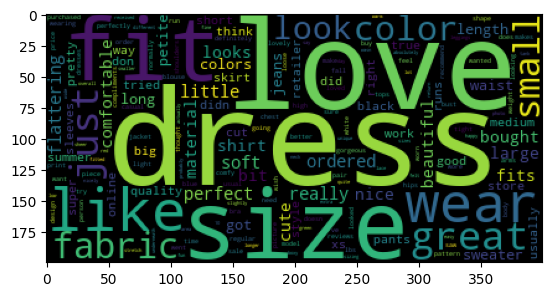

In [154]:
# Finding the words in the text and their frequency
vectorizer_ct = CountVectorizer(min_df = 2, stop_words='english')
X = vectorizer_ct.fit_transform(df_txt['Review Text'])
word_counts = np.sum(X.toarray(), axis=0)
word_freq = dict(zip(vectorizer_ct.get_feature_names_out(), word_counts))

# Creating a plotting a wordcloud based on frequencies
wc = WordCloud().generate_from_frequencies(word_freq)
plt.imshow(wc)

We are going to be using rating data initially, so it is worth looking at the distribution.

5


C:\Users\eltur\AppData\Local\Temp\ipykernel_20332\1002502704.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),


,Rating,count
0,5,13131
1,4,5077
2,3,2871
3,2,1565
4,1,842


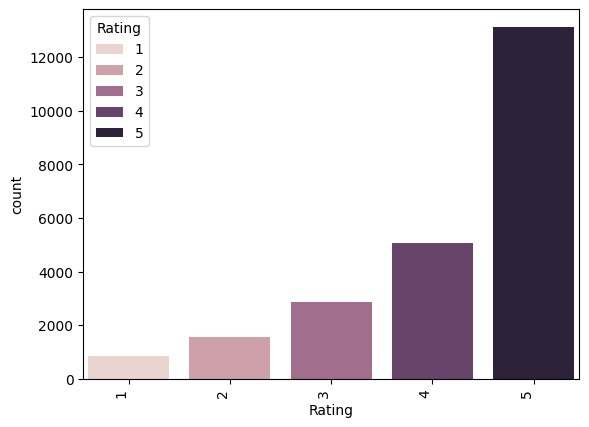

In [157]:
freq_df = pd.DataFrame(df['Rating'].value_counts()).reset_index()
freq_df.columns = ['Rating', 'count']
ncats = len(freq_df)
print(ncats)
ax = sns.barplot(data=freq_df, x='Rating', y='count', hue='Rating')
ax.set_xticklabels(ax.get_xticklabels(), 
                          rotation=90, 
                          horizontalalignment='right')
plt.margins(x=0.01)
freq_df.head()

## Model Building and Training  

The primary question of this analysis that I wanted to answer as an unsupervised question is to look at ratings for each item, and see if there are clusters in the rating patterns for the items.  Because that doesn't feel like a 'final project' level question, I will ask follow up questions after answering that motivating question.

The first step is encoding the data for the analysis.

In [167]:
# Extract just the 'Clothing ID' and 'Rating' columns
df_id_rating = df_0.iloc[:,[1,5]]

# Build a data frame with a count of each possible rating for each Clothing ID
counts= df_id_rating.groupby(['Rating']).value_counts()
rating_counts = counts_r.unstack(fill_value = 0).T
rating_counts

Rating,1,2,3,4,5
Clothing ID,,,,,
0,0,0,0,0,1
1,0,1,0,0,2
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
1201,0,0,1,0,1
1202,0,0,2,2,5
1203,0,0,1,3,7


Here we note that the clothing IDs run from 0 to 1205, which was probably done as part of the process of anonymizing the data.  We are going to cluster with KMeans, which is sensitive to metric, and hence scaling, so we will standardize this data before clustering.

In [266]:
# Turning the dataframe into an array and standardizing rows
rating_std = np.array(rating_counts)
rating_std = rating_std/np.linalg.norm(rating_std, axis = -1)[:, np.newaxis]

rating_std.shape

(1206, 5)

We are ready to run a clustering algorithm on the data.  I am going to start with 5 clusters.

In [244]:
# Our first model, 
KME = KMeans(n_clusters=5, max_iter = 300)
KMM = KME.fit_predict(rating_std)
print(np.unique_counts(KMM))

KME.cluster_centers_

UniqueCountsResult(values=array([0, 1, 2, 3, 4], dtype=int32), counts=array([333, 130, 155,  69, 519]))


array([[0.05599887, 0.1027003 , 0.16662806, 0.46642951, 0.80675728],
       [0.01963025, 0.04046891, 0.87744309, 0.07596143, 0.19407276],
       [0.03134661, 0.01732501, 0.02319663, 0.97039016, 0.05596531],
       [0.39722156, 0.58785851, 0.09299863, 0.11223832, 0.04873146],
       [0.01823253, 0.03148116, 0.03938163, 0.02418563, 0.97802368]])

The array is the centers of the clusters produced by the algorithm.  In the first row, we see a centroid where most reviews are 5, but with a significant number of 4 ratings, I'm going to call this cluster (4,5).  For the second row, there is a high number of 5 ratings, with only a few outlying ratings, a cluster I'm naming (5).  The remaining clusters are (3), (4) and (1,2) respectively.  However, there is no reason why there should be 5 types of clusters.  

The scikit-learn documentation recommends using the silouette score to choose the number of clusters.  

In [289]:
X = rating_std

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 2025 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=3310, n_init = 30)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    #sample_silhouette_values = silhouette_samples(X, cluster_labels)

For n_clusters = 2 The average silhouette_score is : 0.5323461286370241
For n_clusters = 3 The average silhouette_score is : 0.5613934284562556
For n_clusters = 4 The average silhouette_score is : 0.5909514296117888
For n_clusters = 5 The average silhouette_score is : 0.552876718132165
For n_clusters = 6 The average silhouette_score is : 0.5716213762209298
For n_clusters = 7 The average silhouette_score is : 0.5975052099237816
For n_clusters = 8 The average silhouette_score is : 0.6103365287407004


In [296]:
KME4 = KMeans(n_clusters=4, max_iter = 300, random_state=3310, n_init=30)
KMM4 = KME4.fit_predict(rating_std)
print(np.unique_counts(KMM4))
KME4.cluster_centers_

UniqueCountsResult(values=array([0, 1, 2, 3], dtype=int32), counts=array([756, 269,  61, 120]))


array([[0.03074404, 0.0584339 , 0.08310615, 0.13576485, 0.94325256],
       [0.03739729, 0.05290637, 0.09479129, 0.84876859, 0.26451968],
       [0.44931619, 0.57860086, 0.07680089, 0.04060425, 0.05512247],
       [0.01848832, 0.04453337, 0.89161859, 0.02057861, 0.21578186]])

In [295]:
print(KMM4)

[2 2 0 ... 2 0 2]


(4), (1,2), (5), (3)

Note: I tried categorizing just the items with multiple ratings, but the breakdown of classes was very similar.

In [300]:
vectorizer = TfidfVectorizer(min_df = 2, stop_words='english')
vect_matrix = vectorizer.fit_transform(df_txt['Review Text'])
MF_two = NMF(n_components= 2)
factorization_two = MF_two.fit_transform(vect_matrix)
MF_five = NMF(n_components = 5)
factorization_five = MF_five.fit_transform(vect_matrix)

In [302]:
print(factorization_two.shape)
print(factorization_five.shape)

(22628, 2)
(22628, 5)


In [303]:
# Initial predictions are the column index with the highest entry
predictions_two = np.argmax(factorization_two, axis = 1)
predictions_five = np.argmax(factorization_five, axis = 1)
print(predictions_two)
print(predictions_five)

[1 1 0 ... 0 1 1]
[2 3 0 ... 3 1 1]


In [306]:
np.sum(df_txt['Recommended IND'] - predictions_two)/len(predictions_two)

np.float64(0.5946172883153615)

In [328]:
df_txt['Rating']
P = np.array(range(1,6))
print(P)

[1 2 3 4 5]


In [325]:
 Y= pd.DataFrame(df_txt['Rating'], columns = ['Rating'])
Y['Predicted'] = predictions_five
print(Y)

       Rating  Predicted
0           4          2
1           5          3
2           3          0
3           5          2
4           5          4
...       ...        ...
23481       5          1
23482       3          3
23483       3          3
23484       3          1
23485       5          1

[22628 rows x 2 columns]


In [331]:
def numeric_to_labels(y_pred, print_matrix = False):
    # Building a data frame with predictions and true values from the training data
    Y= pd.DataFrame(df_txt['Rating'], columns = ['Rating'])
    Y['Predicted'] = y_pred

    # Count predicted (numeric) labels for each label (training predictions)
    Z = np.zeros((5,5))
    grouped = Y.groupby(['Rating'])
    for l in range(5):
        just_l = grouped.get_group(P[l])
        unique, counts = np.unique(just_l['Predicted'], return_counts=True)
        for i in range(len(unique)):
            Z[l][unique[i]] = counts[i]
    if print_matrix:
        print(Z)

    # Matching integer label and true labels
    best = 0
    A = set(range(5))
    for i in A:
        R = A.difference({i})
        for j in R:
            S = R.difference({j})
            for k in S:
                T = S.difference({k})
                for l in T:
                    U = T.difference({l})
                    m = U.pop()
                    correct_count = Z[0][i] + Z[1][j] + Z[2][k] + Z[3][l] + Z[4][m]
                    if correct_count > best:
                        best = correct_count
                        labelorder = (i,j,k,l,m)
    
    # Calculate accuracy on training data
    acc =best/len(Y['Predicted'])

    # Using the reordering information to create a dictionary
    cat_labels = dict(zip(labelorder, P))

    return cat_labels, acc

In [332]:
category_labels, accuracy = numeric_to_labels(predictions_five, print_matrix=True)
print(category_labels)
print('Training Accuracy:', accuracy)

[[  77.  127.   54.  479.   84.]
 [ 167.  214.   81.  940.  147.]
 [ 395.  393.  184. 1617.  234.]
 [ 848.  706.  910. 2095.  349.]
 [1715. 2025. 4730. 3244.  813.]]
{4: np.int64(1), 1: np.int64(2), 0: np.int64(3), 3: np.int64(4), 2: np.int64(5)}
Training Accuracy: 0.3322432384656178


C:\Users\eltur\AppData\Local\Temp\ipykernel_20332\2759314936.py:10: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  just_l = grouped.get_group(P[l])


In [ ]:
# Relabel test predictions using the dictionary
naive_train_label_pred = [category_labels[predicted] for predicted in naive_train_predictions]

print('True labels:', y_train[:10])
print('Predicted labels:',naive_train_label_pred[:10])

True labels:         Category  Predicted
0       business          1
1       business          0
2       business          0
3           tech          4
4       business          0
5       politics          1
6          sport          2
7  entertainment          3
8       business          0
9  entertainment          3
Predicted labels: ['politics', 'business', 'business', 'tech', 'business', 'politics', 'sport', 'entertainment', 'business', 'entertainment']


In [ ]:
def predict_test_label(vector, MatFac, cat_labels):
    # Transform the test data into a TF-IDF matrix.
    test_numeric = vector.transform(X_test)
    
    # Then, use the matrix factorization basis find the coefficient of each component.
    test_matrix = MatFac.transform(test_numeric)

    # Make predictions as with training data based on the column index with the highest entry.
    test_pred = np.argmax(test_matrix, axis = 1)
  
    # Relabel training predictions using the dictionary
    test_cat = [cat_labels[predicted] for predicted in test_pred]

    return test_cat

In [ ]:
naive_predictions = predict_test_label(vectorizer_naive, MF_naive, category_labels)

# Explorations below here.  Save to another file before finalizing, then delete and upload to GitHub

## Questions
1) Do I want to lose an entire column or 16% of my data?
2) Predict rating from text
3) Do similar groupings to other rating systems
4) Binary predition, recommemd?
5) Categories: age, clothing type (top, dress, bottom, general, general, general petite, intimates)
6) Does petite clothing seems to have more issues?  Less mindful design?  
(Are older/younger or top/bottoms/dresses/jackets more picky?) 
7) Clustering based on ratings on categories, see if they have other characteristics similar
8) Lengths of reviews, positive vs negative, recommend?
9) Maybe take 10 minutes to remove words like top/bottom/shirt/jeans/jacket to prevent clustering by type,
to make the clusterings or groupings more "blind" to garment.
re.sub() # 
10) People who rate both petite and non-petite

Go to scikit-learn, but there is also tensorflow (lost of math thoughts, more for neural networks) or pytorch 

Step 1) Cleaning the data, preprocessing the data.
Make all lower case
Get rid of weird symbols like emojis (probably aren't any)
And all punctuation or ??? or !!!
Get rid of those words (garment specific)
Two blocks and run twice, one with garment specific words and one without

Step 2) TF-IDF Vectorizer, .fit_transform, borrow a lot of code
Step 3) Use similarity clustering, maybe a k-means analysis (should only be a couple lines of code)
Step 4) PCA?
Step 5) Use the matrix non-negative matrix factorization, compare results with actual, see if these clusters match up with the ratings (probably won't match up nicely)

Start doing things like thinking about ages and clothing, make a few plots like age to review, etc.

Or go fully unsupervised and make some predictions, 

Try the words both with the recommended and with the class name, do a two-cluster, recommended or non-recommended, try to predict document class, let it run and come back

Be careful with numbers, but maybe age vs how many words are in the review, does length combined with age have anything to do with ratings.

Question: Are there patterns within the reviews by objectID?
Question: Do we use all items, or only some with a cutoff number of reviews?  (Unfair if only have 3 or fewer reviews to use in analysis.)
Question: If we standardize, will the clustering be able to pull out the items with lots of reviews?  i.e. there should be some connection between positive reviews and number or reviews



Baby scenario:
1 [2,2,2,2,2] -- [ 0,5,0,0,0]
2 [1,1] -- [ 2, 0,0,0,0]
3 [1,2,3,4,5] --[1,1,1,1,1]
4 [5,5,5,5,5,5,5,5,5,5,5,5,5,1] -- [1,0,0,0,13]

1) Encode
2) standardize??? Does the total number of reviews matter?  How much should it matter?
3) Bring in a 6th dimension which is percent of overall ratings or as a rank within total counts?  

Plan: Initial k-means, encode by counts, keep everybody, standardize, start with initial cluster size of 5, tune to find best number of clusters

In [18]:
naive = df_0.iloc[:,[1,5]]
naive

,Clothing ID,Rating
0,767,4
1,1080,5
2,1077,3
3,1049,5
4,847,5
...,...,...
23481,1104,5
23482,862,3
23483,1104,3
23484,1084,3


In [19]:
counts = naive.groupby(['Clothing ID']).value_counts()
counts

Clothing ID  Rating
0            5         1
1            5         2
             2         1
2            4         1
3            5         1
                      ..
1203         4         3
             3         1
1204         4         1
             5         1
1205         5         2
Name: count, Length: 2521, dtype: int64

In [20]:
counts.loc[820]

Rating
5    130
4     41
1     14
3     14
2     12
Name: count, dtype: int64

'Clothing ID'  'Rating Vector'
0               [0,0,0,0,1]
820             [14, 12, 14, 41, 130]/||that vector||

In [22]:
counts = counts.unstack(fill_value = 0)
counts

Rating  Clothing ID
1       0              0
        1              0
        2              0
        3              0
        4              0
                      ..
5       1201           1
        1202           5
        1203           7
        1204           1
        1205           2
Length: 6030, dtype: int64

In [ ]:
counts = counts(lambda rating: your function here)

In [51]:
counts_r = naive.groupby(['Rating']).value_counts()

id_rating_matrix = counts_r.unstack(fill_value = 0).T
id_rating_matrix

Rating,1,2,3,4,5
Clothing ID,,,,,
0,0,0,0,0,1
1,0,1,0,0,2
2,0,0,0,1,0
3,0,0,0,0,1
4,0,0,0,0,1
...,...,...,...,...,...
1201,0,0,1,0,1
1202,0,0,2,2,5
1203,0,0,1,3,7


class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')

(mess around with lloyd without too much work, could be interesting, ditto max_iter, which can get you out of a hole if you've climbed into a hole, either of those before tolerance )

In [67]:
id_rating = id_rating_matrix.iloc[:,0:5]
id_rating



Rating,2,3,4,5
Clothing ID,,,,
0,0,0,0,1
1,1,0,0,2
2,0,0,1,0
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
1201,0,1,0,1
1202,0,2,2,5
1203,0,1,3,7


In [ ]:
from sklearn.cluster import KMeans 

KME = KMeans(n_clusters=5)
KMM = KME.fit_predict(id_rating_matrix)

np.unique_counts(KMM)

KME2 = KMeans(n_clusters=5, max_iter = 5)
KMM2 = KME2.fit_predict(id_rating_matrix)
np.unique_counts(KMM2)

matrix_std = np.array(id_rating_matrix)
matrix_std

result = matrix_std/np.linalg.norm(matrix_std, axis = -1)[:, np.newaxis]
result

KME2 = KMeans(n_clusters=5, max_iter = 300)
KMM2 = KME2.fit_predict(result)
np.unique_counts(KMM2)

KME2.cluster_centers_

KME3 = KMeans(n_clusters=8, max_iter = 300)
KMM3 = KME3.fit_predict(result)
np.unique_counts(KMM3)
print(KME3.cluster_centers_)

Classes are (5), (1,2), (4), (4,5), (3) 

What about using standard scaling on columns?

In [ ]:
# No, absolutely not
scalar = StandardScaler()
std_scl_ratings = scalar.fit_transform(rating_counts)
std_scl_ratings

array([[-0.27903652, -0.28468614, -0.27387773, -0.27770216, -0.25303769],
       [-0.27903652, -0.065305  , -0.27387773, -0.27770216, -0.22744746],
       [-0.27903652, -0.28468614, -0.27387773, -0.21173628, -0.27862791],
       ...,
       [-0.27903652, -0.28468614, -0.15883191, -0.0798045 , -0.09949633],
       [-0.27903652, -0.28468614, -0.27387773, -0.21173628, -0.25303769],
       [-0.27903652, -0.28468614, -0.27387773, -0.27770216, -0.22744746]])

What about scaling data so row sum is 1, instead of norm?

In [235]:
multiple_unif = np.array(rating_counts)
multiple_unif = multiple_unif/np.sum(multiple_unif, axis = 1)[:, np.newaxis]

multiple_unif

array([[0.        , 0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.66666667],
       [0.        , 0.        , 0.        , 1.        , 0.        ],
       ...,
       [0.        , 0.        , 0.09090909, 0.27272727, 0.63636364],
       [0.        , 0.        , 0.        , 0.5       , 0.5       ],
       [0.        , 0.        , 0.        , 0.        , 1.        ]])

unsupervised questions, NMF, different numbers, 2, see if mapping is interesting in any way, positive or not, stuff like that, filter by age, cutoff point above and below, petite and non-petite, how does it change the clusters, if they match up to anything?  

For n_clusters = 2025 The average silhouette_score is : 0.589437724537913
For n_clusters = 2904 The average silhouette_score is : 0.5872967349903099
For n_clusters = 33109 The average silhouette_score is : 0.5909514296117888
For n_clusters = 3310 The average silhouette_score is : 0.5909514296117888


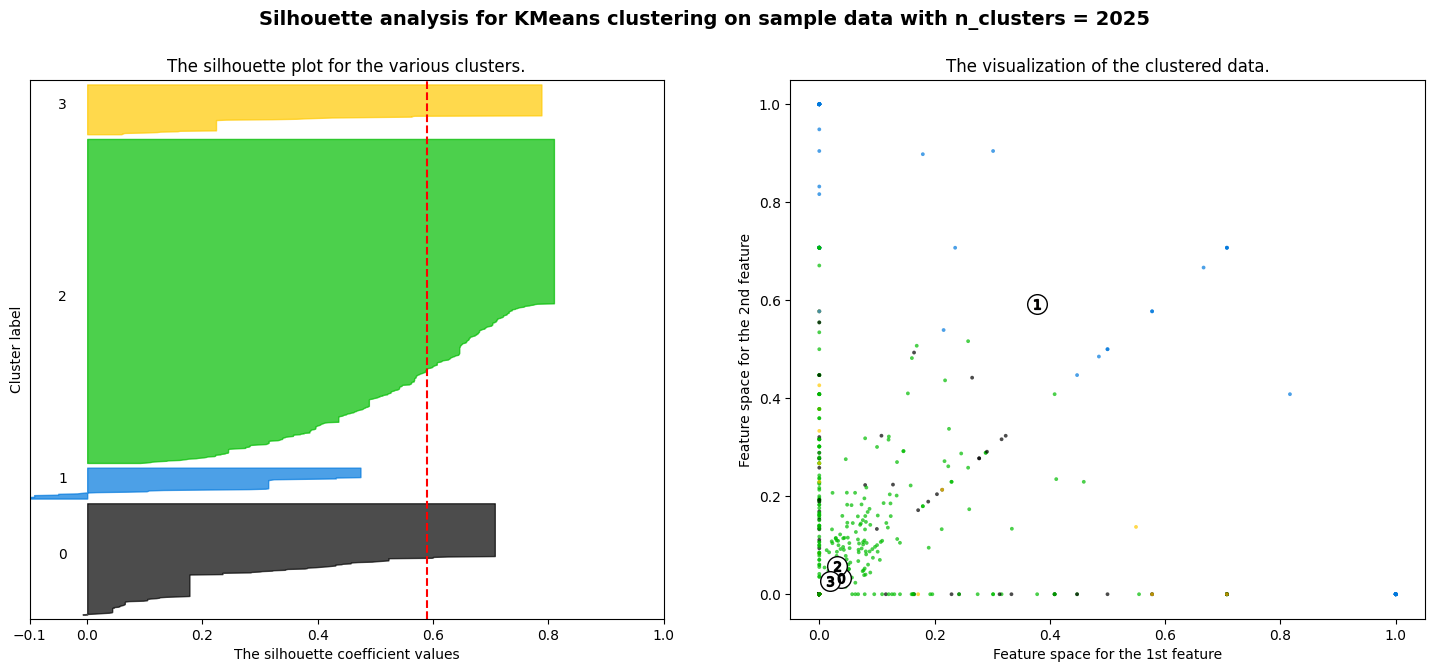

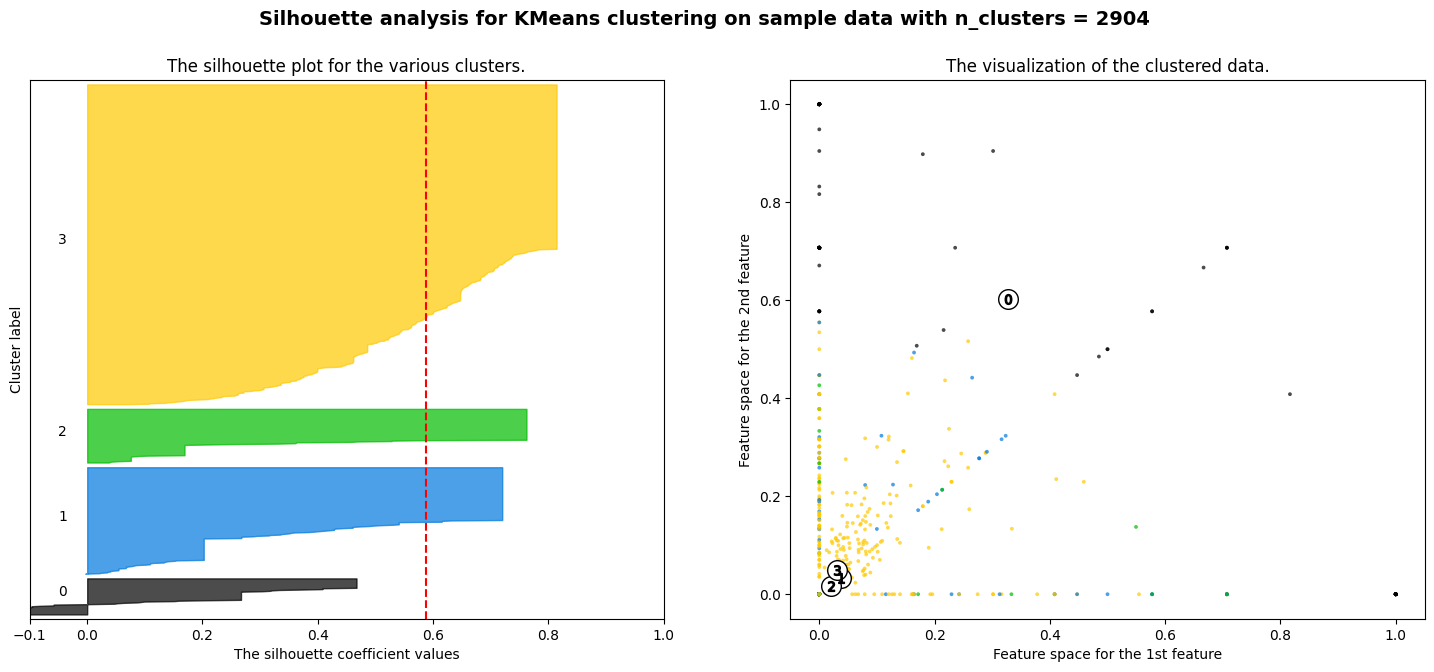

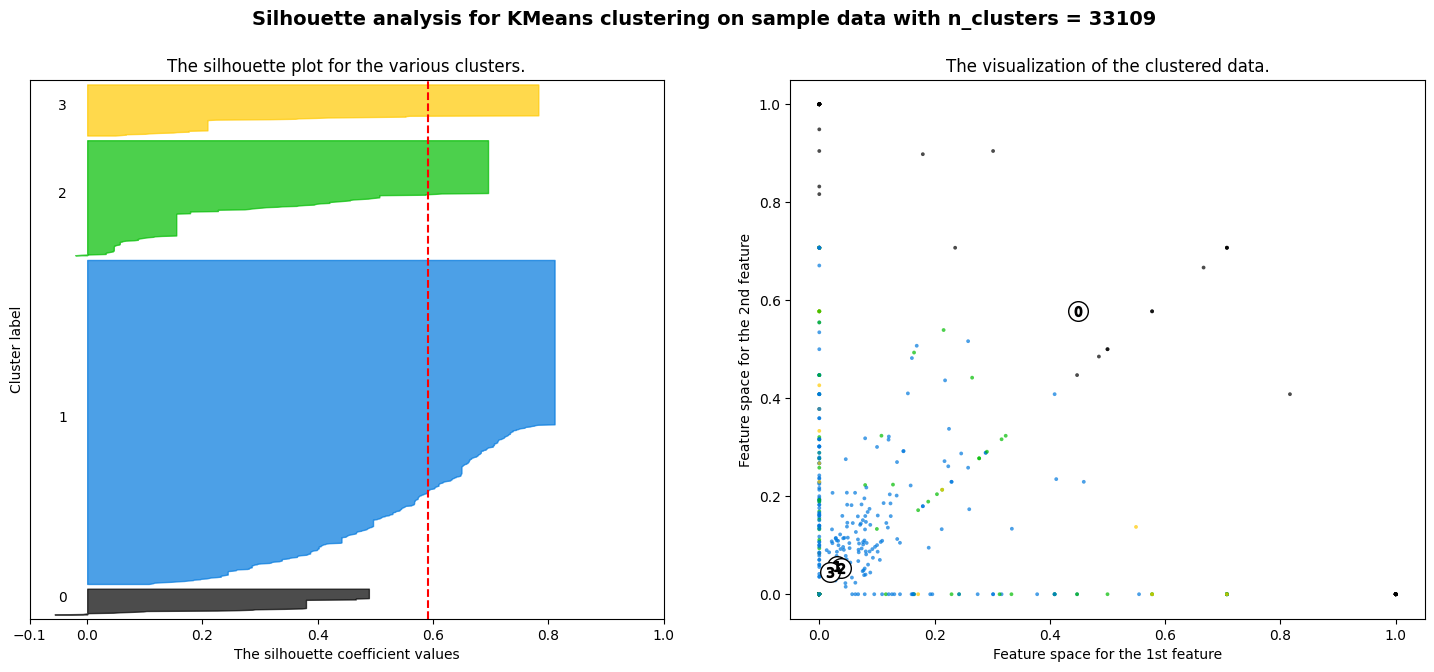

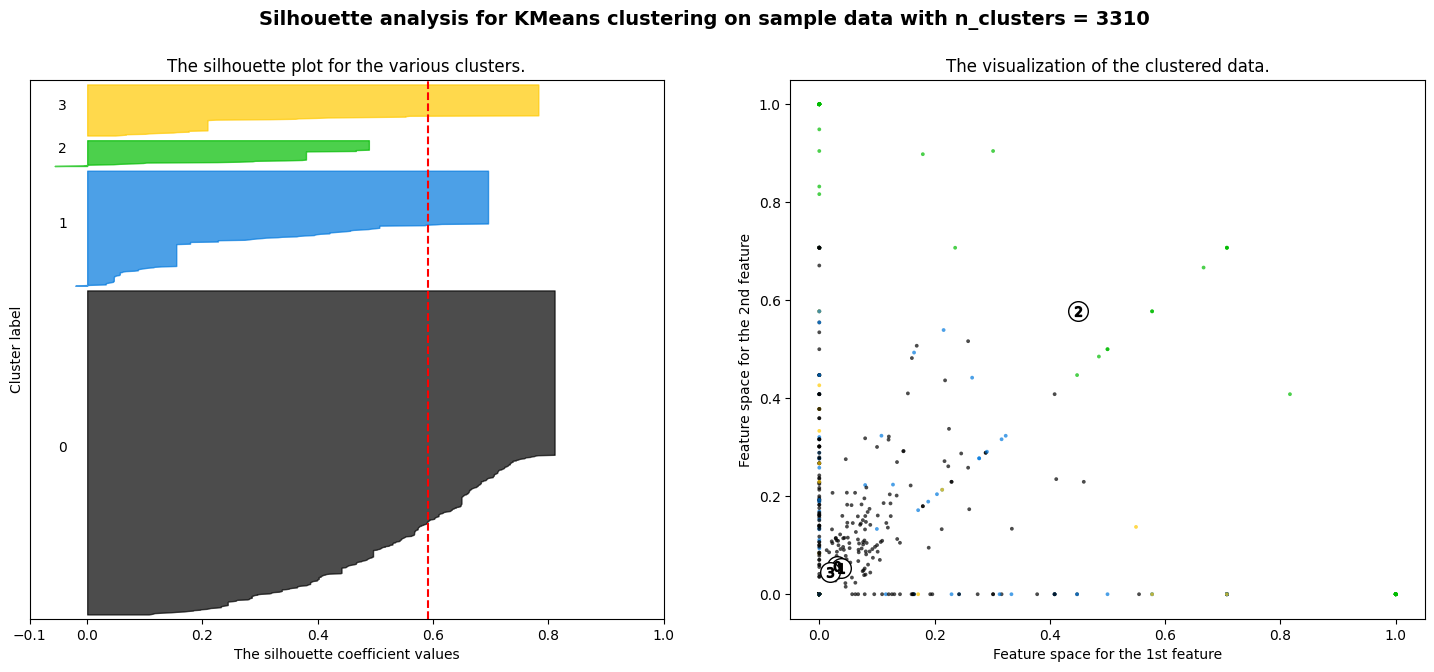

In [288]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

X = rating_std

range_n_clusters = [2025, 2904, 33109, 3310]


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (4 + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=4, random_state=n_clusters, n_init = 30)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(4):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / 4)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.531913306180059
For n_clusters = 3 The average silhouette_score is : 0.5636377430650084
For n_clusters = 4 The average silhouette_score is : 0.5891193120703654
For n_clusters = 5 The average silhouette_score is : 0.550519879435577
For n_clusters = 6 The average silhouette_score is : 0.5716371311261418
For n_clusters = 7 The average silhouette_score is : 0.5975052099237816
For n_clusters = 8 The average silhouette_score is : 0.6124635330091447
For n_clusters = 9 The average silhouette_score is : 0.6287632195342467
For n_clusters = 10 The average silhouette_score is : 0.6385153186660335


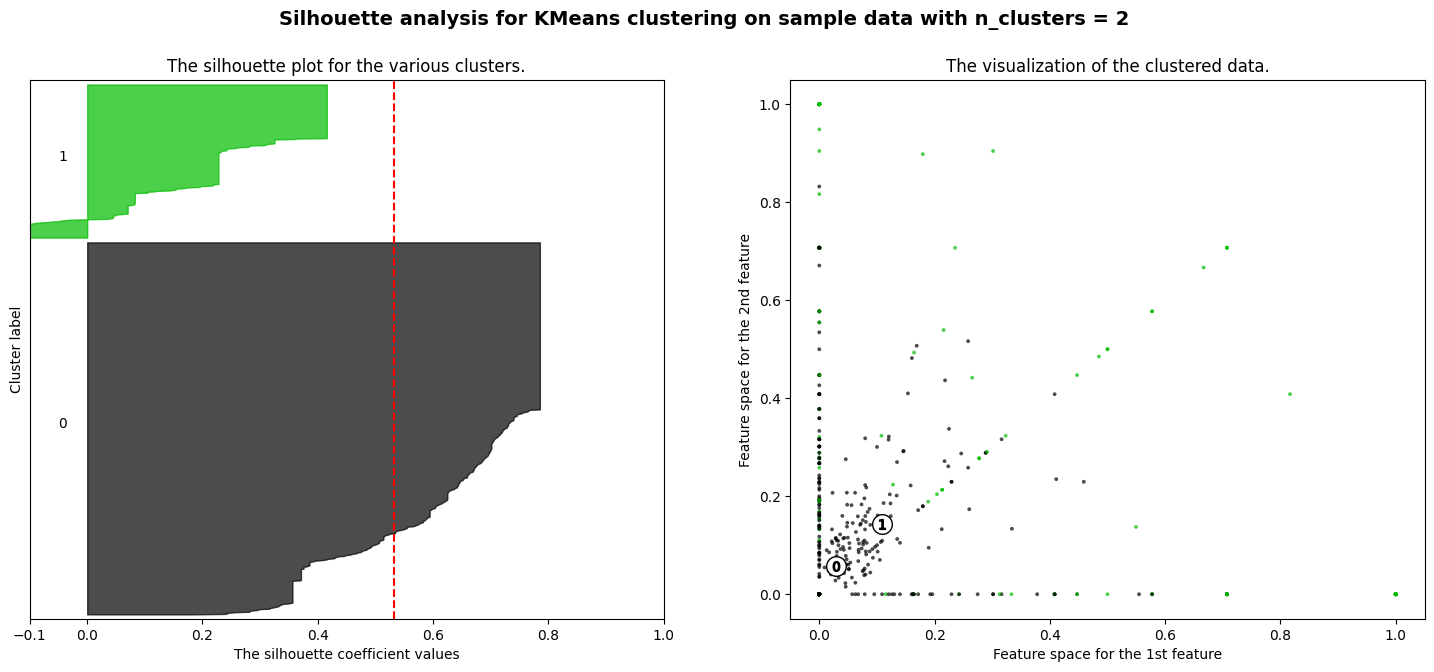

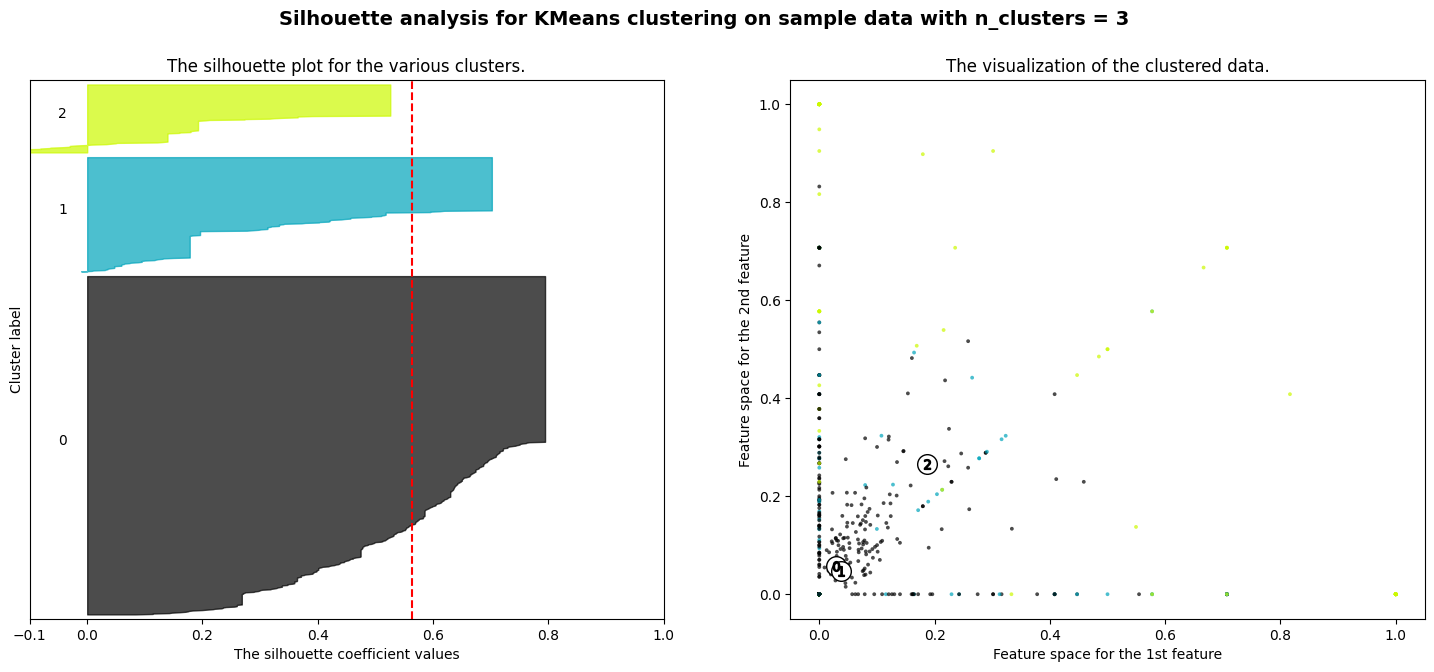

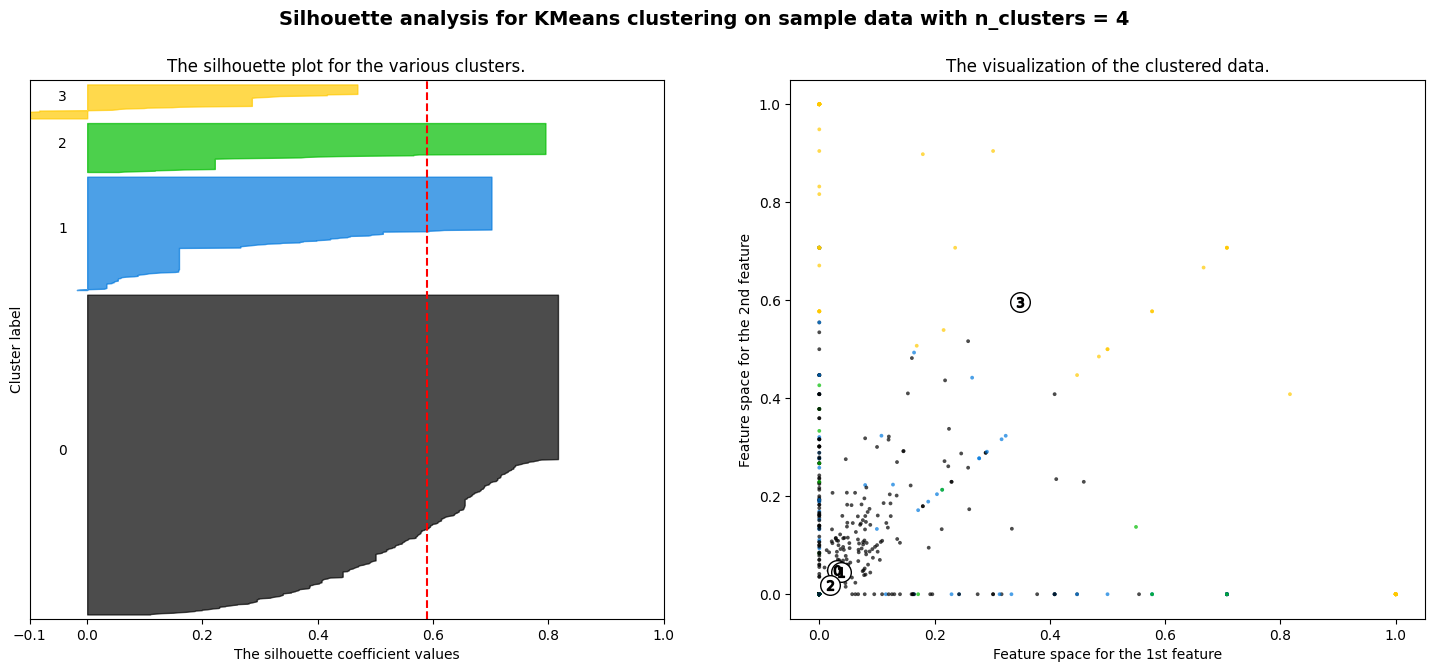

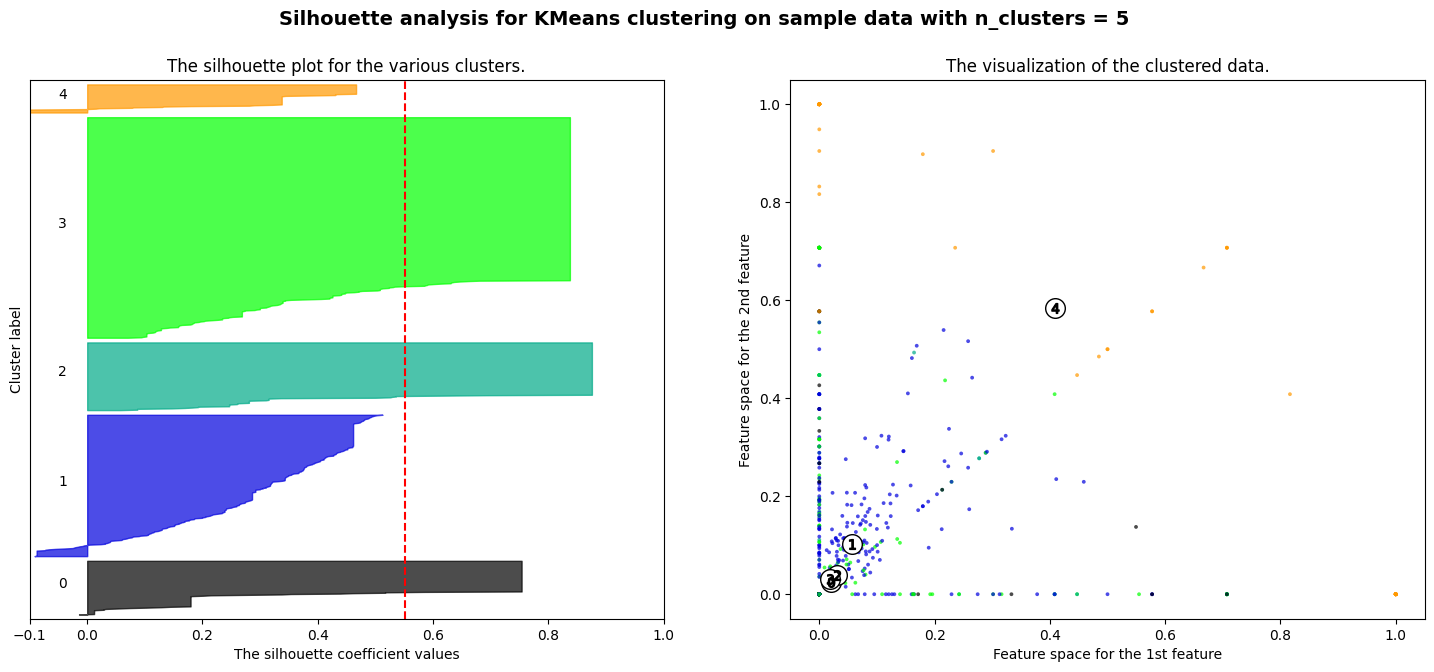

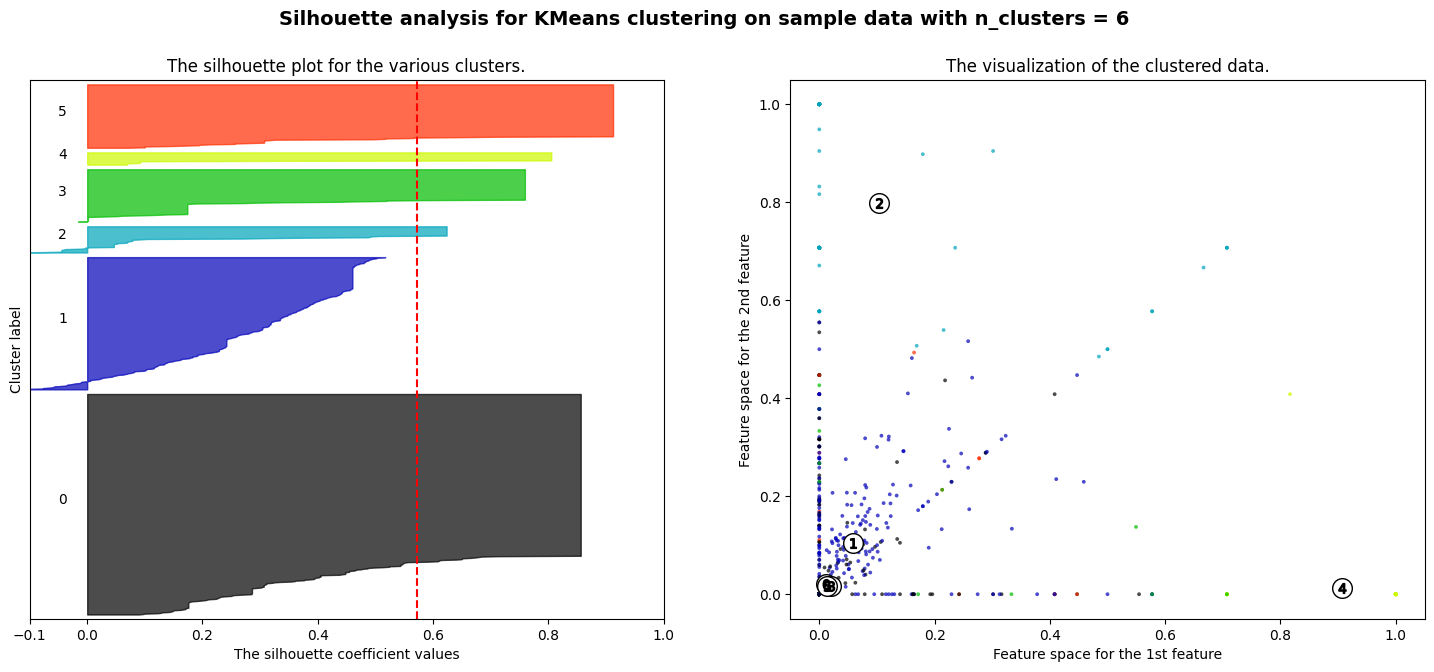

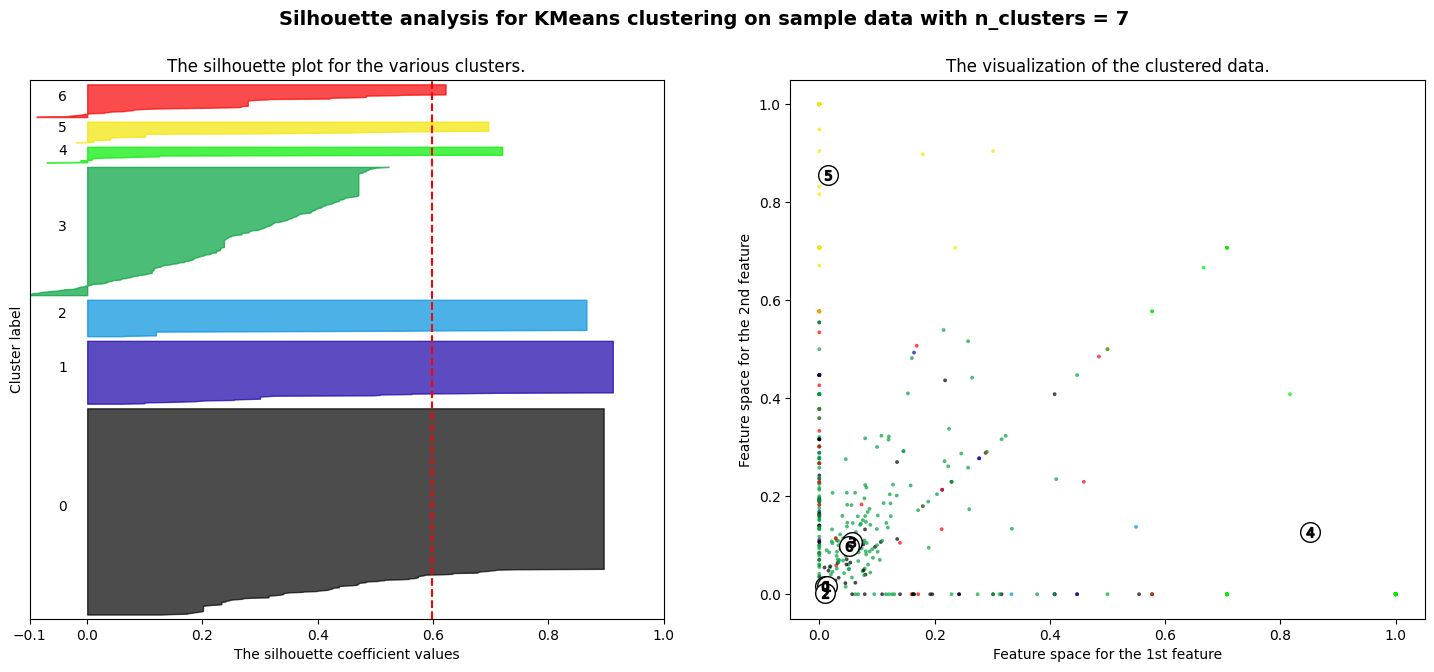

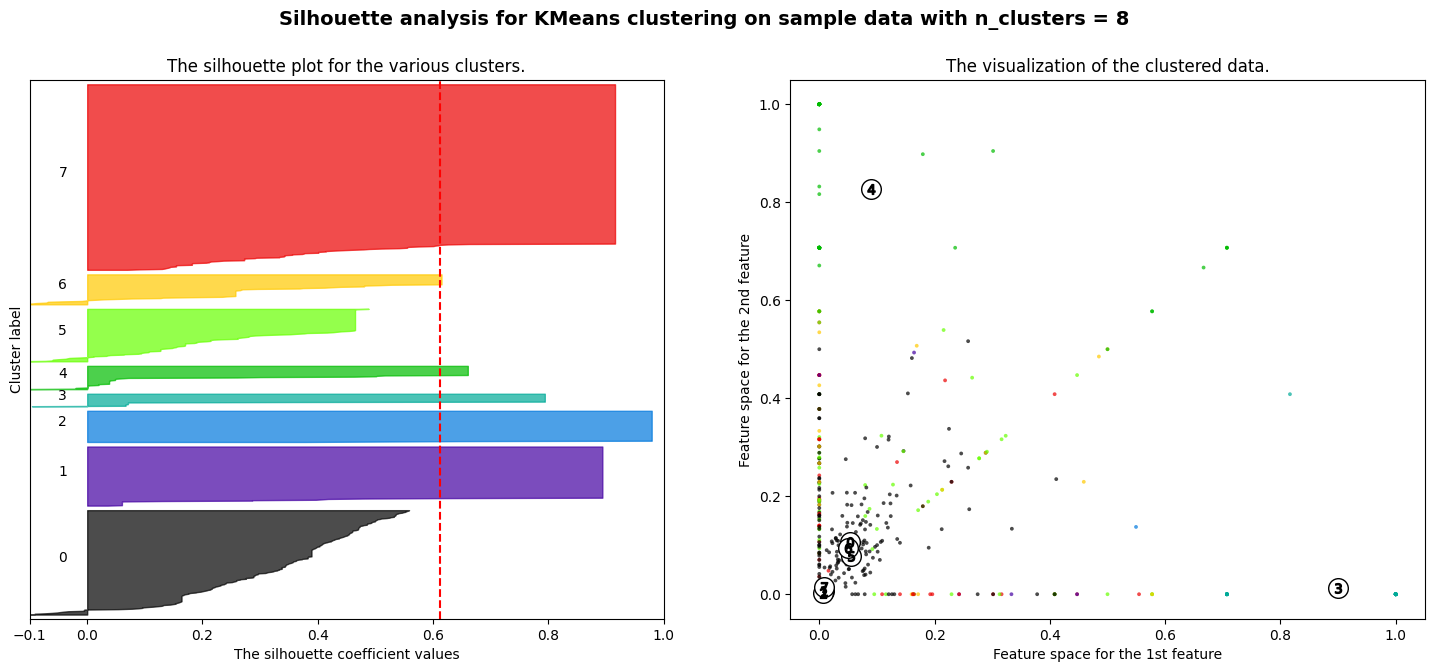

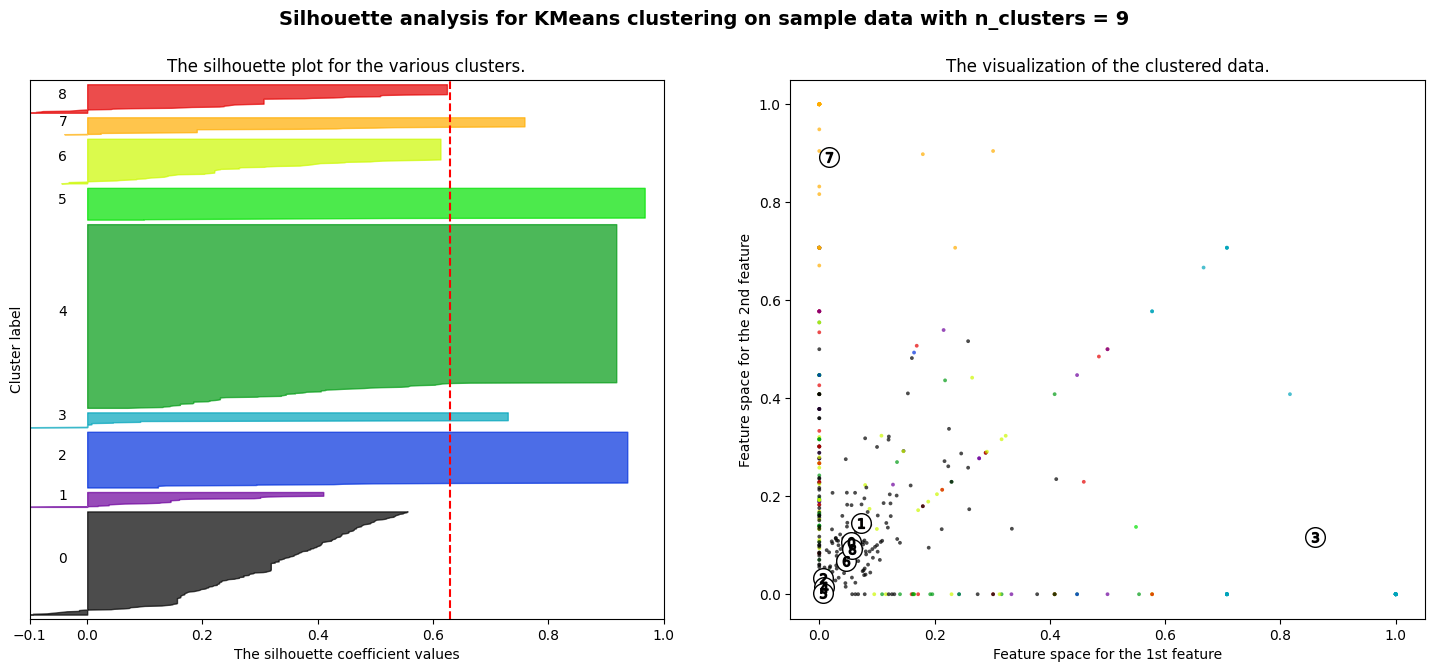

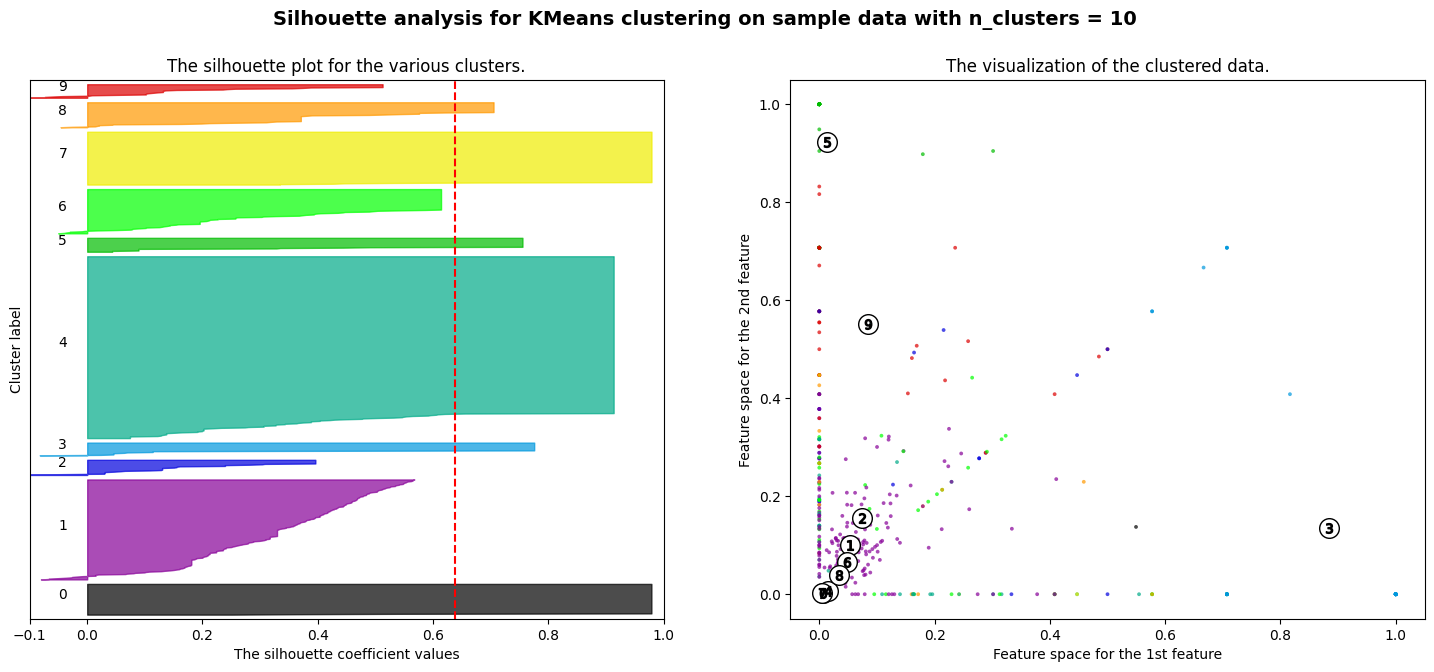

In [ ]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=5,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

X = rating_std

range_n_clusters = [2, 3, 4, 5, 6, 7 ,8 ,9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=31895, n_init = 30)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5323461286370241
For n_clusters = 3 The average silhouette_score is : 0.5601455937449844
For n_clusters = 4 The average silhouette_score is : 0.5884516614114391
For n_clusters = 5 The average silhouette_score is : 0.5539564097643934
For n_clusters = 6 The average silhouette_score is : 0.5693596833956678


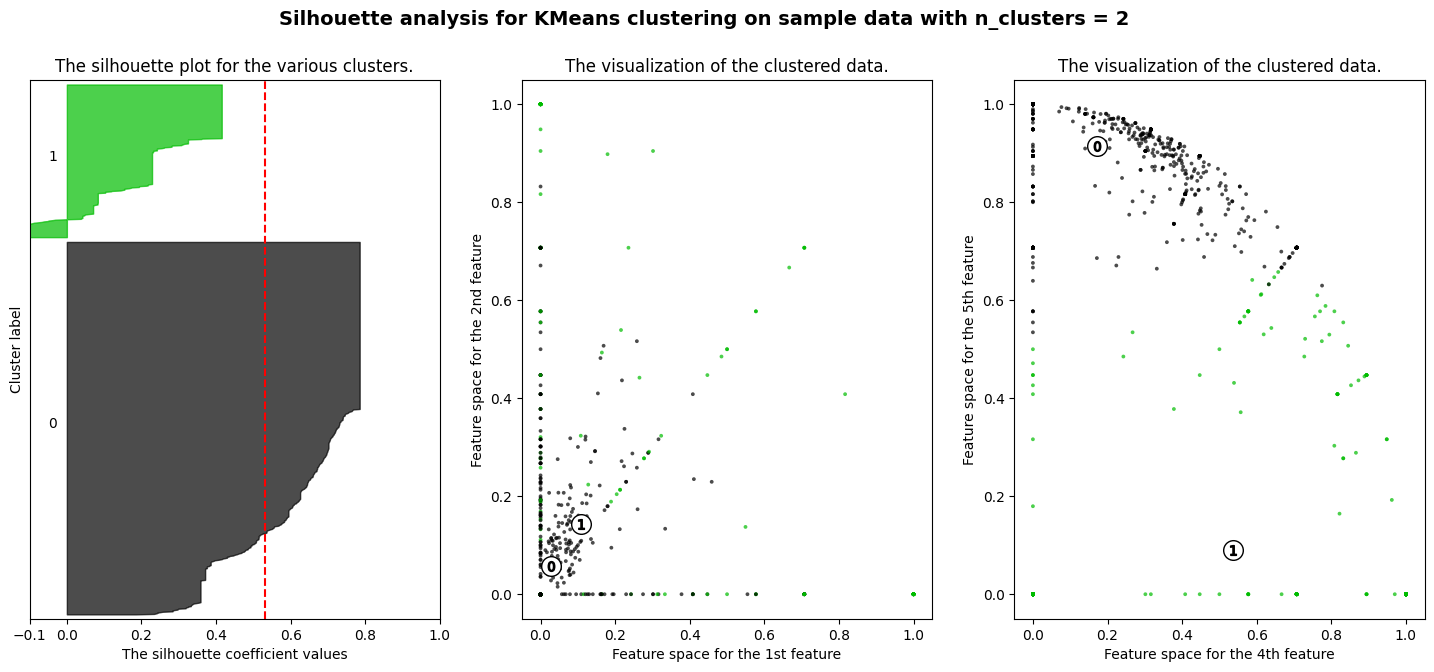

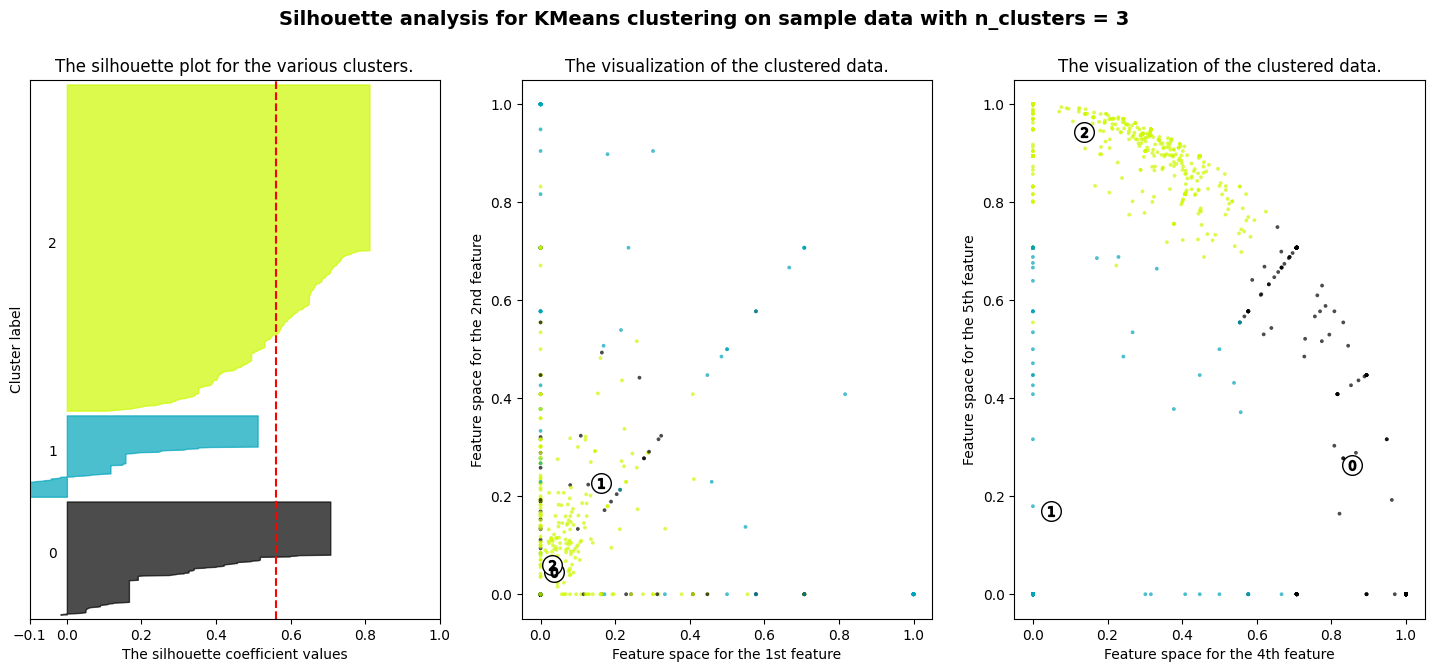

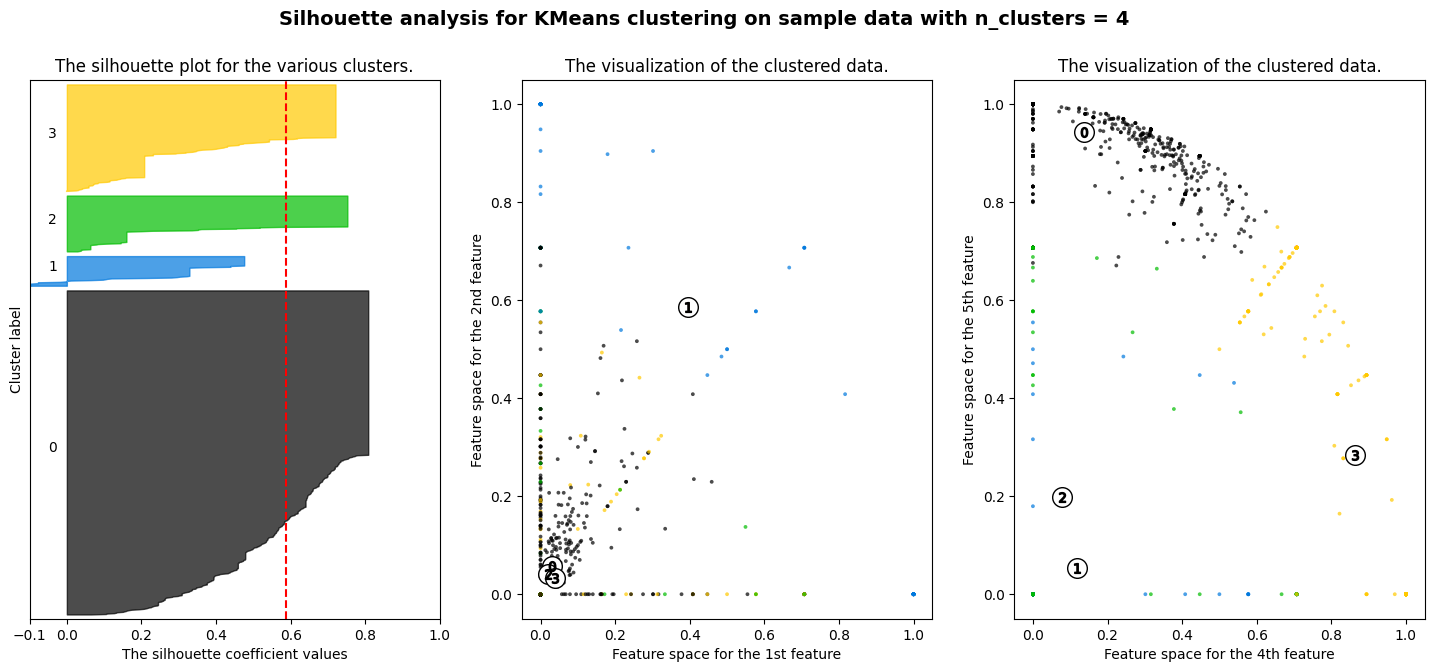

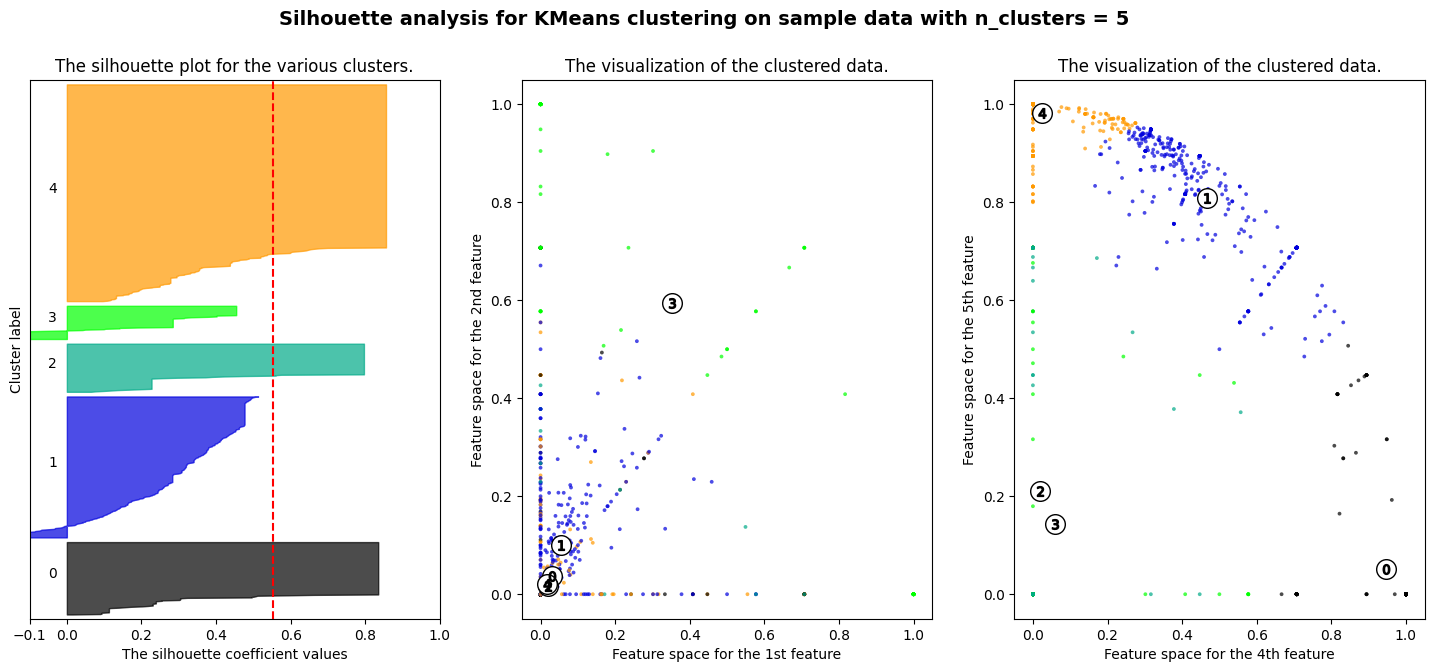

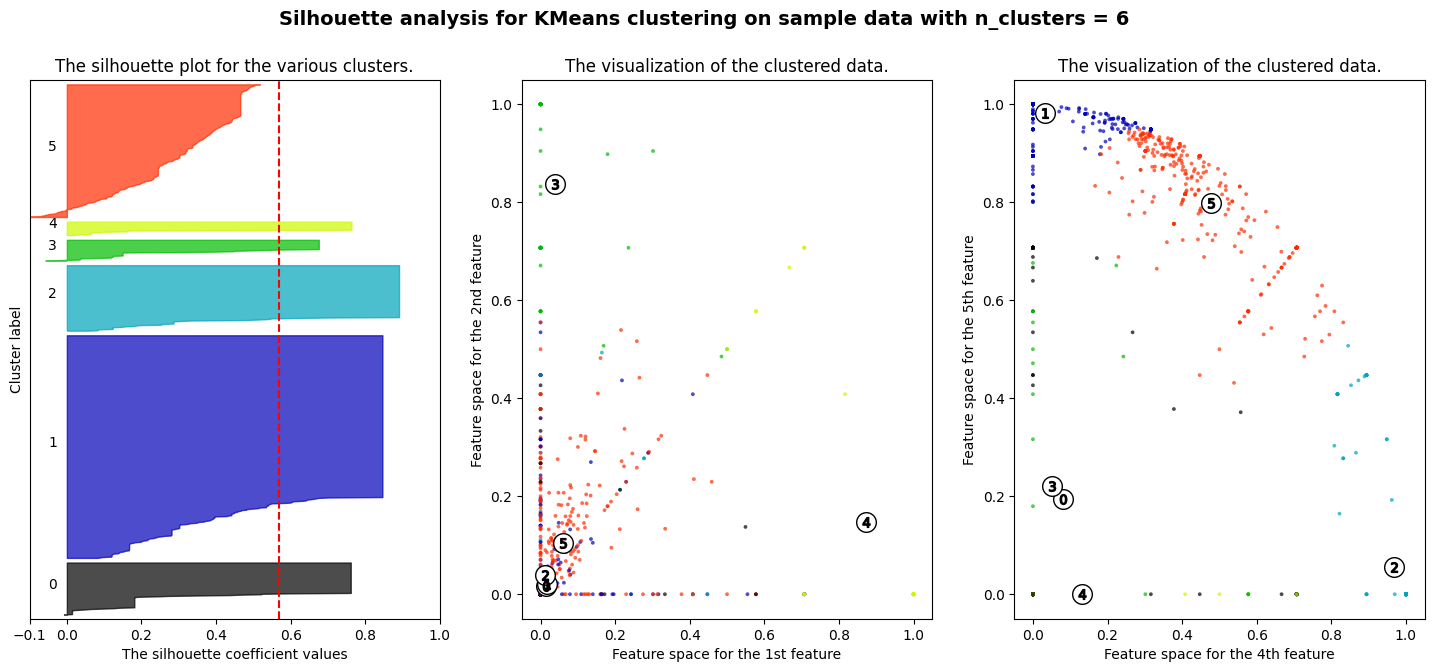

In [254]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X = multiple_std

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 30)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

    # 3nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax3.scatter(
        X[:, 3], X[:, 4], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Draw white circles at cluster centers
    ax3.scatter(
        centers[:, 3],
        centers[:, 4],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax3.scatter(c[3], c[4], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax3.set_title("The visualization of the clustered data.")
    ax3.set_xlabel("Feature space for the 4th feature")
    ax3.set_ylabel("Feature space for the 5th feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )    

plt.show()

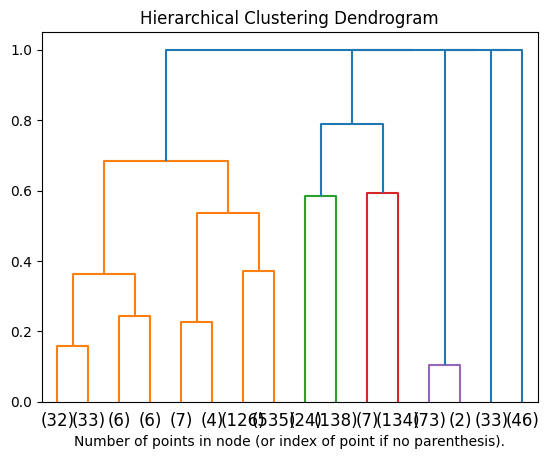

In [251]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import load_iris


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


#iris = load_iris()
#X = iris.data
X = rating_std

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric = 'cosine', linkage='complete')\
#model = AgglomerativeClustering(distance_threshold=None, n_clusters=5, metric = 'cosine', linkage='complete')

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()